In [1]:
# Step 1: load .csv and important rows 

import pandas as pd

csv_path = "texte_mit_top3_sachg_tr_chunked_with_ids_top3.csv"
df = pd.read_csv(csv_path)

# Wähle die Spalten, die wir brauchen 
cols = ["Text", "Top-3 alle", "Translator", "original_row_id", "chunk_id"] # translator, original_row_id and chunk_id to save vector with right translator for later use
df_subset = df[cols]

# Erste 5 Zeilen anzeigen zum Check
print("Erste 5 Zeilen der ausgewählten Spalten:")
print(df_subset.head())


Erste 5 Zeilen der ausgewählten Spalten:
                                                Text  \
0  Auswirkungen Auswirkungen auf den Bund Finanzi...   
1  ##e Zusammenarbeit 2023 – 2028 geplanten Beträ...   
2  Kantone und Gemeinden sowie auf urbane Zentren...   
3  ##chlechter darstellen. Es liegt im Interesse ...   
4  Documentation complémentaire du DFAE Compte 20...   

                                          Top-3 alle Translator  \
0  Die Top 3 Sachgebiete in diesem Text sind: Ent...        kas   
1  Die Top 3 Sachgebiete in diesem Text sind: Ent...        kas   
2  Die Top 3 Sachgebiete in diesem Text sind: Ent...        kas   
3  Die Top 3 Sachgebiete in diesem Text sind: Ent...        kas   
4  Die Top 3 Sachgebiete in diesem Text sind: Str...        bec   

   original_row_id  chunk_id  
0                0         1  
1                0         2  
2                0         3  
3                0         4  
4                1         1  


In [4]:
!pip install sentence-transformers


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 676.3 kB/s eta 0:00:0000:01


In [2]:
# Step 2: load model for embedding and make test embeddings for text

from sentence_transformers import SentenceTransformer

model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

# Test Embedding für die ersten 3 Texte
texts_test = df_subset["Text"].tolist()[:3]
embeds_test = model.encode(texts_test, show_progress_bar=False)

print("\nEmbedding-Form (erste 3 Texte):", embeds_test.shape)
print("Erstes Embedding Beispiel (5 Werte):", embeds_test[0][:5])



Embedding-Form (erste 3 Texte): (3, 384)
Erstes Embedding Beispiel (5 Werte): [-0.13342094 -0.09980048  0.02435276 -0.11903442  0.25849926]


In [3]:
# Step 3: embed text and sentence with top 3 topics

# Texte und Sachgebiet-Texte in Listen
texts = df_subset["Text"].tolist()
topics = df_subset["Top-3 alle"].tolist()

print("\nBerechne Embeddings für Textspalte...")
text_embeds = model.encode(texts, show_progress_bar=True, batch_size=32)

print("Berechne Embeddings für Top-3 alle Spalte...")
topic_embeds = model.encode(topics, show_progress_bar=True, batch_size=32)

print("\nText-Embedding Shape:", text_embeds.shape)
print("Topic-Embedding Shape:", topic_embeds.shape)



Berechne Embeddings für Textspalte...


Batches:   0%|          | 0/202 [00:00<?, ?it/s]

Berechne Embeddings für Top-3 alle Spalte...


Batches:   0%|          | 0/202 [00:00<?, ?it/s]


Text-Embedding Shape: (6450, 384)
Topic-Embedding Shape: (6450, 384)


In [4]:
# Step 4: concatenate vectors

import numpy as np

# Horizontal (nebeneinander) verbinden
embeds_concat = np.hstack([text_embeds, topic_embeds])

print("\nShape concatenated embeddings:", embeds_concat.shape)
print("Beispiel concatenated embedding (erstes Chunk, 5 Werte):", embeds_concat[0][:5])



Shape concatenated embeddings: (6450, 768)
Beispiel concatenated embedding (erstes Chunk, 5 Werte): [-0.13342093 -0.0998005   0.0243527  -0.11903436  0.25849932]


In [5]:
# Step 5: save embeddings and meta data (translator name)

import os

output_dir = "embeddings_output_paraphrase"
os.makedirs(output_dir, exist_ok=True)

# Embeddings speichern
embeddings_file = os.path.join(output_dir, "embeddings_paraphrase.npy")
np.save(embeddings_file, embeds_concat)
print(f"\nEmbeddings gespeichert in: {embeddings_file}")

# Metadaten ohne Text, aber mit Übersetzer und IDs speichern
meta_cols = ["original_row_id", "chunk_id", "Translator", "Top-3 alle"]
meta_df = df_subset[meta_cols]

meta_file = os.path.join(output_dir, "metadata_paraphrase.csv")
meta_df.to_csv(meta_file, index=False)
print(f"Metadaten gespeichert in: {meta_file}")



Embeddings gespeichert in: embeddings_output_paraphrase/embeddings_paraphrase.npy
Metadaten gespeichert in: embeddings_output_paraphrase/metadata_paraphrase.csv


In [6]:
# look at embeddings

import numpy as np

# Embeddings laden
embeddings = np.load("embeddings_output_paraphrase/embeddings_paraphrase.npy")

# Form prüfen
print("Embeddings Shape:", embeddings.shape)

# Erstes Embedding anschauen (nur die ersten 10 Werte für Übersichtlichkeit)
print("\nErstes Embedding (10 Werte):")
print(embeddings[0][:10])


Embeddings Shape: (6450, 768)

Erstes Embedding (10 Werte):
[-0.13342093 -0.0998005   0.0243527  -0.11903436  0.25849932  0.10459307
 -0.19831541  0.18452466  0.04721025  0.1569153 ]


In [7]:
# check embedding and according translator

import numpy as np
import pandas as pd

# Embeddings und Metadaten laden
embeddings = np.load("embeddings_output_paraphrase/embeddings_paraphrase.npy")
metadata = pd.read_csv("embeddings_output_paraphrase/metadata_paraphrase.csv")

# Beispiel: Index auswählen (z.B. 5)
idx = 6449

# Embedding anschauen (nur 5 Werte)
print(f"Embedding {idx} (erste 5 Werte):\n{embeddings[idx][:5]}")

# Passenden Eintrag aus der Metadata anschauen
print("\nZugehörige Metadaten:")
print(metadata.iloc[idx])


Embedding 6449 (erste 5 Werte):
[-0.04037749  0.19402206  0.03143229  0.06582609  0.1869288 ]

Zugehörige Metadaten:
original_row_id                                                  120
chunk_id                                                          16
Translator                                                       lyj
Top-3 alle         Die Top 3 Sachgebiete in diesem Text sind: Fri...
Name: 6449, dtype: object


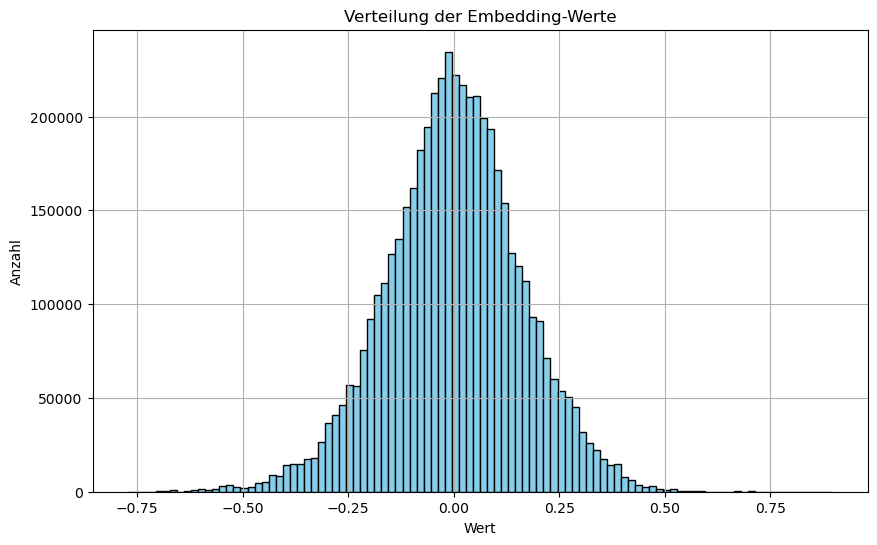

In [8]:
# plot

import matplotlib.pyplot as plt

# Alle Werte der Embeddings zu einem langen Array machen
all_values = embeddings.flatten()

# Plot
plt.figure(figsize=(10,6))
plt.hist(all_values, bins=100, color="skyblue", edgecolor="black")
plt.title("Verteilung der Embedding-Werte")
plt.xlabel("Wert")
plt.ylabel("Anzahl")
plt.grid(True)
plt.show()


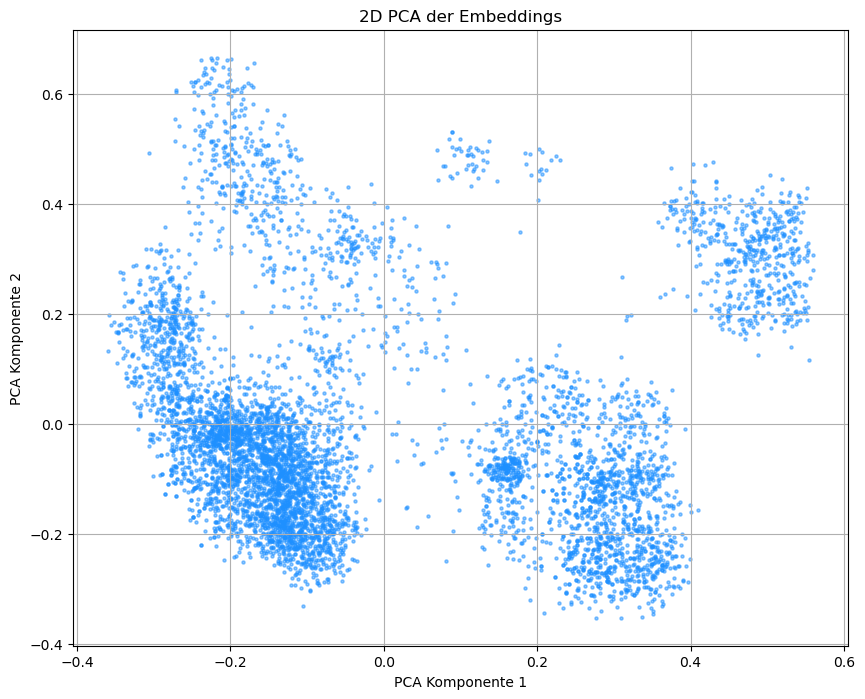

In [15]:
# PCA (principal component analysis)

from sklearn.decomposition import PCA

# PCA auf 2 Dimensionen
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plotten
plt.figure(figsize=(10,8))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], s=5, alpha=0.5, c='dodgerblue')
plt.title("2D PCA der Embeddings")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.grid(True)
plt.show()

# Komponente 1 zeigt: Worin unterscheiden sich die Texte am meisten?

# Komponente 2 zeigt: Worin unterscheiden sie sich als Nächstes?


/scratch/local/20276805/ipykernel_3358291/3338183740.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(unique_translators))


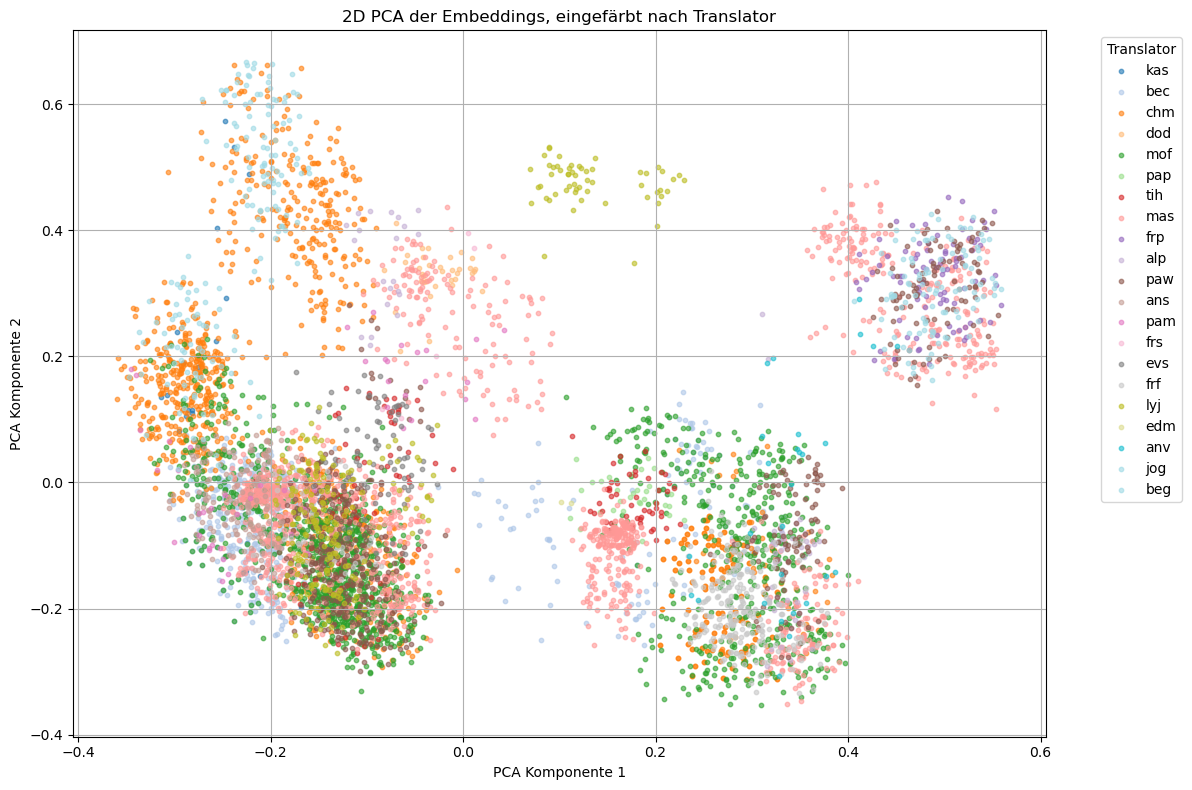

In [16]:
# pca to see if texts from same translator are clustering

import matplotlib.pyplot as plt

# PCA hast du schon gemacht, embeddings_2d ist da

# Metadata laden, falls noch nicht geladen
import pandas as pd
metadata = pd.read_csv("embeddings_output/metadata.csv")

# Wir nutzen den Translator als Kategorie
translators = metadata['Translator']

# Eindeutige Translator-Namen
unique_translators = translators.unique()

# Farben für jeden Translator generieren
import matplotlib.cm as cm
import numpy as np
colors = cm.get_cmap('tab20', len(unique_translators))

plt.figure(figsize=(12,8))

for i, translator in enumerate(unique_translators):
    indices = translators == translator
    plt.scatter(
        embeddings_2d[indices, 0],
        embeddings_2d[indices, 1],
        s=10,
        alpha=0.6,
        color=colors(i),
        label=translator
    )

plt.title("2D PCA der Embeddings, eingefärbt nach Translator")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.legend(title="Translator", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


/scratch/local/20276805/ipykernel_3358291/1095033493.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(unique_topics))


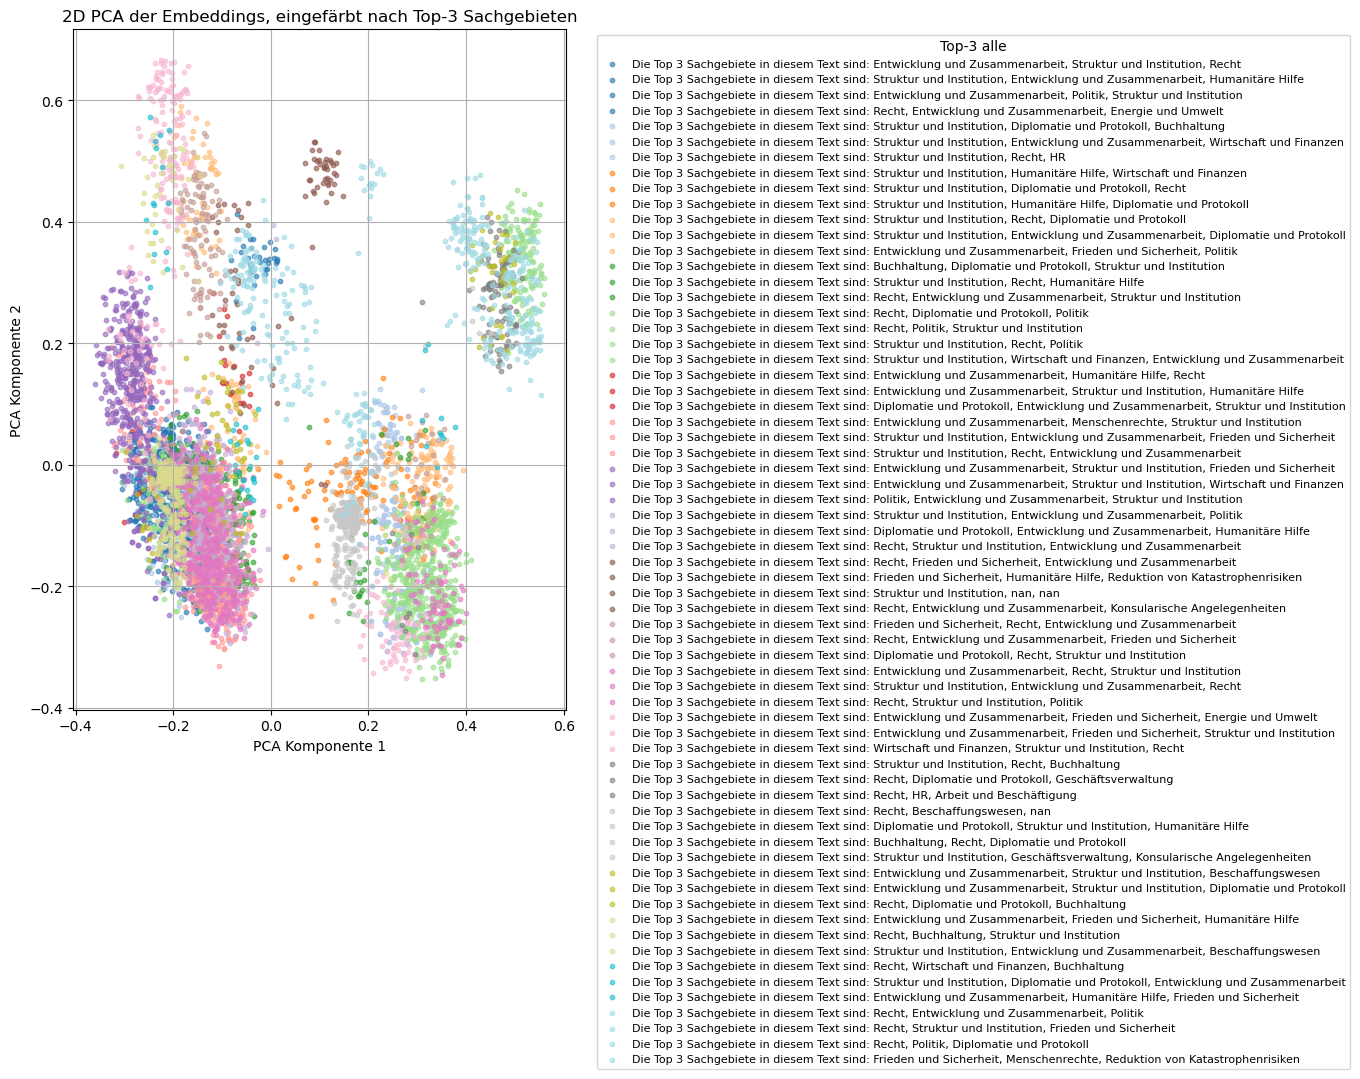

In [19]:
# pca for topics

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

metadata = pd.read_csv("embeddings_output/metadata.csv")

topics = metadata['Top-3 alle']
unique_topics = topics.unique()

# Farben generieren (alt-kompatibel)
cmap = cm.get_cmap('tab20', len(unique_topics))

plt.figure(figsize=(14,10))

for i, topic in enumerate(unique_topics):
    indices = topics == topic
    plt.scatter(
        embeddings_2d[indices, 0],
        embeddings_2d[indices, 1],
        s=10,
        alpha=0.6,
        color=cmap(i),
        label=topic
    )

plt.title("2D PCA der Embeddings, eingefärbt nach Top-3 Sachgebieten")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.legend(title="Top-3 alle", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

